# Importing in data

In [ ]:
import csv
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas as pd
import plotly.express as px
import time
import random
from scipy.stats import beta

In [ ]:
customers = pd.read_csv('data/bonus_VIP_customers.csv')
customers.head()

,Survey ResponseID,Prime,Free Trial,Email CTC,Display Ad CTC,Video Ad CTC,Search Engine Ad CTC,Social Media Ad CTC,Average CTC,Express Shipping,Cart Abandonment Rate,Check Review,Refund rate,Time in Cart,Time on Page,RFM
0,R_03aEbghUILs9NxD,0,0,0.000000,0.152505,0.000000,0.084507,0.000000,0.049471,0.357143,0.733693,0,0.243994,7.039021,0.469268,111
1,R_06RZP9pS7kONINr,1,1,0.022101,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.709685,1,0.170417,45.151821,3.010121,323
2,R_085qq7w0pkhowox,1,1,0.142079,0.025374,0.000000,0.000000,0.010455,0.036060,1.000000,0.719513,1,0.306721,19.751185,1.316746,322
3,R_08uYA7fb4unHGkF,1,1,0.000000,0.000000,0.061927,0.000000,0.000000,0.000000,1.000000,0.645122,0,0.118960,13.694138,0.912943,223
4,R_0BrMxYYMHVMOBEJ,1,1,0.000000,0.000000,0.118639,0.046602,0.000000,0.035160,1.000000,0.832793,0,0.343723,2.544373,0.169625,212


In [ ]:
purchases = pd.read_csv('data/purchases.csv')
purchases.head()

,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Survey ResponseID,Category,Prime,Discounts,Express Shipping
0,2018-12-04,7.98,1,NJ,SanDisk Ultra 16GB Class 10 SDHC UHS-I Memory ...,B0143RTB1E,R_01vNIayewjIIKMF,Electronics,1,0.00,1
1,2018-12-22,13.99,1,NJ,Betron BS10 Earphones Wired Headphones in Ear ...,B01MA1MJ6H,R_01vNIayewjIIKMF,Electronics,1,0.00,1
2,2018-12-24,8.99,1,NJ,NaN,B078JZTFN3,R_01vNIayewjIIKMF,NaN,1,0.00,1
3,2018-12-25,10.45,1,NJ,Perfecto Stainless Steel Shaving Bowl. Durable...,B06XWF9HML,R_01vNIayewjIIKMF,Kitchen & Dining,1,0.05,1
4,2018-12-25,10.00,1,NJ,Proraso Shaving Cream for Men,B00837ZOI0,R_01vNIayewjIIKMF,Beauty & Personal Care,1,0.05,1


In [ ]:
demographics = pd.read_csv('data/survey.csv')
demographics.info()

# Data preparation for model training

### Getting RFM of customers 1 year after first purchase

In [ ]:
# Get all orders within 1 year from first order date

purchases['Order Date'] = pd.to_datetime(purchases['Order Date'])

first_order_dates = purchases.groupby('Survey ResponseID')['Order Date'].min().reset_index()
first_order_dates.columns = ['Survey ResponseID', 'first_order_date']

purchases = purchases.merge(first_order_dates, on='Survey ResponseID')
purchases['one_year_cutoff'] = purchases['first_order_date'] + pd.DateOffset(years=1)
one_year_orders = purchases[purchases['Order Date'] <= purchases['one_year_cutoff']]

one_year_orders.head()

,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Survey ResponseID,Category,Prime,Discounts,Express Shipping,first_order_date,one_year_cutoff
0,2018-12-04,7.98,1,NJ,SanDisk Ultra 16GB Class 10 SDHC UHS-I Memory ...,B0143RTB1E,R_01vNIayewjIIKMF,Electronics,1,0.00,1,2018-12-04,2019-12-04
1,2018-12-22,13.99,1,NJ,Betron BS10 Earphones Wired Headphones in Ear ...,B01MA1MJ6H,R_01vNIayewjIIKMF,Electronics,1,0.00,1,2018-12-04,2019-12-04
2,2018-12-24,8.99,1,NJ,NaN,B078JZTFN3,R_01vNIayewjIIKMF,NaN,1,0.00,1,2018-12-04,2019-12-04
3,2018-12-25,10.45,1,NJ,Perfecto Stainless Steel Shaving Bowl. Durable...,B06XWF9HML,R_01vNIayewjIIKMF,Kitchen & Dining,1,0.05,1,2018-12-04,2019-12-04
4,2018-12-25,10.00,1,NJ,Proraso Shaving Cream for Men,B00837ZOI0,R_01vNIayewjIIKMF,Beauty & Personal Care,1,0.05,1,2018-12-04,2019-12-04


In [ ]:
# RFM of each customer after 1 year from 1st purchase date

one_year_orders['Year'] = one_year_orders['Order Date'].dt.year
one_year_orders['Month'] = one_year_orders['Order Date'].dt.month
one_year_orders['Recency'] = one_year_orders['first_order_date'] + pd.DateOffset(years=1) - one_year_orders.groupby(['Survey ResponseID'])['Order Date'].transform("max")
one_year_orders['Frequency'] = one_year_orders.groupby(['Survey ResponseID'])['Order Date'].transform('nunique')
one_year_orders['Order value'] = one_year_orders['Quantity'] * one_year_orders['Purchase Price Per Unit']
one_year_orders['Monetary'] = one_year_orders.groupby(['Survey ResponseID'])['Order value'].transform('sum')
one_year_orders['Monetary'] = one_year_orders['Monetary']/one_year_orders['Frequency']
one_year_orders['Frequency'] = 365/one_year_orders['Frequency']
one_year_orders = one_year_orders[['Recency','Frequency','Monetary','Survey ResponseID']]
one_year_orders = one_year_orders.drop_duplicates()
one_year_orders['Recency'] = one_year_orders['Recency'].dt.days

print(one_year_orders['Frequency'].describe())
print(one_year_orders['Monetary'].describe())
print(one_year_orders['Recency'].describe())

conditions_recency = [
    one_year_orders['Recency'] <= 30,
    (one_year_orders['Recency'] > 30) & (one_year_orders['Recency'] <= 365),
    one_year_orders['Recency'] > 365
]

conditions_frequency = [
    one_year_orders['Frequency'] <= 7,
    (one_year_orders['Frequency'] > 7) & (one_year_orders['Frequency'] < 30),
    one_year_orders['Frequency'] >= 30
]

conditions_monetary = [
    one_year_orders['Monetary'] <= 35,
    (one_year_orders['Monetary'] > 35) & (one_year_orders['Monetary'] < 65),
    one_year_orders['Monetary'] >= 65
]
choices_RF = [3,2,1]
choices_M = [1,2,3]
one_year_orders['Recency_category'] = np.select(conditions_recency, choices_RF, default= 'Unknown')
one_year_orders['Frequency_category'] = np.select(conditions_frequency, choices_RF, default= 'Unknown')
one_year_orders['Monetary_category'] = np.select(conditions_monetary, choices_M, default= 'Unknown')
one_year_orders['RFM'] = one_year_orders['Recency_category'].astype(str) + one_year_orders['Frequency_category'].astype(str) + one_year_orders['Monetary_category'].astype(str)
print(one_year_orders['RFM'].value_counts().sort_index(ascending= False))
lifetime_rfm = one_year_orders[['Survey ResponseID','RFM']].drop_duplicates()


customers = pd.merge(customers, lifetime_rfm, on='Survey ResponseID', how='inner')

<ipython-input-363-8464ad19ae6a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_year_orders['Year'] = one_year_orders['Order Date'].dt.year
<ipython-input-363-8464ad19ae6a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_year_orders['Month'] = one_year_orders['Order Date'].dt.month
<ipython-input-363-8464ad19ae6a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

count    4923.000000
mean       51.358016
std        76.057780
min         1.372180
25%        10.735294
50%        22.812500
75%        52.142857
max       365.000000
Name: Frequency, dtype: float64
count    4923.000000
mean       51.204542
std        38.698645
min         0.100000
25%        29.646901
50%        42.536186
75%        61.115000
max       769.475000
Name: Monetary, dtype: float64
count    4923.000000
mean       60.644119
std        98.177855
min         0.000000
25%         4.000000
50%        16.000000
75%        60.000000
max       366.000000
Name: Recency, dtype: float64
RFM
333    109
332    376
331    128
323    423
322    903
321    552
313    147
312    232
311    282
233      3
232     11
231      2
223     74
222    149
221    135
213    285
212    422
211    653
113      3
112     10
111     24
Name: count, dtype: int64


In [ ]:
customers[customers['RFM_y'] == '333'].shape[0]

109

In [ ]:
customers.drop('RFM_x', axis=1, inplace=True)
customers.rename(columns={'RFM_y': 'RFM_1year'}, inplace=True)
customers.head()

,Survey ResponseID,Prime,Free Trial,Email CTC,Display Ad CTC,Video Ad CTC,Search Engine Ad CTC,Social Media Ad CTC,Average CTC,Express Shipping,Cart Abandonment Rate,Check Review,Refund rate,Time in Cart,Time on Page,RFM_1year
0,R_03aEbghUILs9NxD,0,0,0.000000,0.152505,0.000000,0.084507,0.000000,0.049471,0.357143,0.733693,0,0.243994,7.039021,0.469268,321
1,R_06RZP9pS7kONINr,1,1,0.022101,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.709685,1,0.170417,45.151821,3.010121,322
2,R_085qq7w0pkhowox,1,1,0.142079,0.025374,0.000000,0.000000,0.010455,0.036060,1.000000,0.719513,1,0.306721,19.751185,1.316746,322
3,R_08uYA7fb4unHGkF,1,1,0.000000,0.000000,0.061927,0.000000,0.000000,0.000000,1.000000,0.645122,0,0.118960,13.694138,0.912943,323
4,R_0BrMxYYMHVMOBEJ,1,1,0.000000,0.000000,0.118639,0.046602,0.000000,0.035160,1.000000,0.832793,0,0.343723,2.544373,0.169625,212


In [ ]:
# Labelling customers that have '333' for RFM csore as VIP
customers['VIP'] = customers['RFM_1year'].apply(lambda x: 1 if x == '333' else 0)
customers.head()

,Survey ResponseID,Prime,Free Trial,Email CTC,Display Ad CTC,Video Ad CTC,Search Engine Ad CTC,Social Media Ad CTC,Average CTC,Express Shipping,Cart Abandonment Rate,Check Review,Refund rate,Time in Cart,Time on Page,RFM_1year,VIP
0,R_03aEbghUILs9NxD,0,0,0.000000,0.152505,0.000000,0.084507,0.000000,0.049471,0.357143,0.733693,0,0.243994,7.039021,0.469268,321,0
1,R_06RZP9pS7kONINr,1,1,0.022101,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.709685,1,0.170417,45.151821,3.010121,322,0
2,R_085qq7w0pkhowox,1,1,0.142079,0.025374,0.000000,0.000000,0.010455,0.036060,1.000000,0.719513,1,0.306721,19.751185,1.316746,322,0
3,R_08uYA7fb4unHGkF,1,1,0.000000,0.000000,0.061927,0.000000,0.000000,0.000000,1.000000,0.645122,0,0.118960,13.694138,0.912943,323,0
4,R_0BrMxYYMHVMOBEJ,1,1,0.000000,0.000000,0.118639,0.046602,0.000000,0.035160,1.000000,0.832793,0,0.343723,2.544373,0.169625,212,0


### Getting RFM of customers 3 months after 1st purchase

However, we will not group them into a 3 digit RFM score, instead we will leave the 'Recency', 'Frequency' and 'Monetary' in raw numerical form to be used for model prediction.

In [ ]:
# Get all orders up till 3 months from first order

purchases['3_month_cutoff'] = purchases['first_order_date'] + pd.DateOffset(months=3)
three_mth_orders = purchases[purchases['Order Date'] <= purchases['3_month_cutoff']]

three_mth_orders.head()

,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Survey ResponseID,Category,Prime,Discounts,Express Shipping,first_order_date,one_year_cutoff,3_month_cutoff
0,2018-12-04,7.98,1,NJ,SanDisk Ultra 16GB Class 10 SDHC UHS-I Memory ...,B0143RTB1E,R_01vNIayewjIIKMF,Electronics,1,0.00,1,2018-12-04,2019-12-04,2019-03-04
1,2018-12-22,13.99,1,NJ,Betron BS10 Earphones Wired Headphones in Ear ...,B01MA1MJ6H,R_01vNIayewjIIKMF,Electronics,1,0.00,1,2018-12-04,2019-12-04,2019-03-04
2,2018-12-24,8.99,1,NJ,NaN,B078JZTFN3,R_01vNIayewjIIKMF,NaN,1,0.00,1,2018-12-04,2019-12-04,2019-03-04
3,2018-12-25,10.45,1,NJ,Perfecto Stainless Steel Shaving Bowl. Durable...,B06XWF9HML,R_01vNIayewjIIKMF,Kitchen & Dining,1,0.05,1,2018-12-04,2019-12-04,2019-03-04
4,2018-12-25,10.00,1,NJ,Proraso Shaving Cream for Men,B00837ZOI0,R_01vNIayewjIIKMF,Beauty & Personal Care,1,0.05,1,2018-12-04,2019-12-04,2019-03-04


In [ ]:
three_mth_orders['Year'] = three_mth_orders['Order Date'].dt.year
three_mth_orders['Month'] = three_mth_orders['Order Date'].dt.month
three_mth_orders['Recency'] = three_mth_orders['first_order_date'] + pd.DateOffset(months=3) - three_mth_orders.groupby(['Survey ResponseID'])['Order Date'].transform("max")
three_mth_orders['Frequency'] = three_mth_orders.groupby(['Survey ResponseID'])['Order Date'].transform('nunique')
three_mth_orders['Order value'] = three_mth_orders['Quantity'] * three_mth_orders['Purchase Price Per Unit']
three_mth_orders['Monetary'] = three_mth_orders.groupby(['Survey ResponseID'])['Order value'].transform('sum')
three_mth_orders['Monetary'] = three_mth_orders['Monetary']/three_mth_orders['Frequency']
three_mth_orders['Frequency'] = 91/three_mth_orders['Frequency']
three_mth_orders = three_mth_orders[['Recency','Frequency','Monetary','Survey ResponseID']]
three_mth_orders = three_mth_orders.drop_duplicates()
three_mth_orders['Recency'] = three_mth_orders['Recency'].dt.days

print(one_year_orders['Frequency'].describe())
print(one_year_orders['Monetary'].describe())
print(one_year_orders['Recency'].describe())

temp_df = three_mth_orders[['Survey ResponseID', 'Recency', 'Frequency', 'Monetary']].drop_duplicates()

customers = pd.merge(customers, temp_df, on='Survey ResponseID', how='inner')

count    4923.000000
mean       51.358016
std        76.057780
min         1.372180
25%        10.735294
50%        22.812500
75%        52.142857
max       365.000000
Name: Frequency, dtype: float64
count    4923.000000
mean       51.204542
std        38.698645
min         0.100000
25%        29.646901
50%        42.536186
75%        61.115000
max       769.475000
Name: Monetary, dtype: float64
count    4923.000000
mean       60.644119
std        98.177855
min         0.000000
25%         4.000000
50%        16.000000
75%        60.000000
max       366.000000
Name: Recency, dtype: float64


<ipython-input-368-a955b383a459>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  three_mth_orders['Year'] = three_mth_orders['Order Date'].dt.year
<ipython-input-368-a955b383a459>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  three_mth_orders['Month'] = three_mth_orders['Order Date'].dt.month
<ipython-input-368-a955b383a459>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [ ]:
customers = customers[['Survey ResponseID', 'Recency', 'Frequency', 'Monetary', 'RFM_1year', 'VIP']]
customers.head()

,Survey ResponseID,Recency,Frequency,Monetary,RFM_1year,VIP
0,R_03aEbghUILs9NxD,56,30.333333,11.803333,321,0
1,R_06RZP9pS7kONINr,10,15.166667,69.838333,322,0
2,R_085qq7w0pkhowox,5,13.000000,41.718571,322,0
3,R_08uYA7fb4unHGkF,0,18.200000,115.952000,323,0
4,R_0BrMxYYMHVMOBEJ,89,91.000000,61.980000,212,0


### Adding in additional demographics data that might help with prediction

In [ ]:
demographics = demographics[['Survey ResponseID', 'Q-demos-income', 'Q-amazon-use-howmany', 'Q-amazon-use-hh-size', 'Q-demos-state']]
customers = pd.merge(customers, demographics, on='Survey ResponseID', how='inner')

In [ ]:
customers.head()

,Survey ResponseID,Recency,Frequency,Monetary,RFM_1year,VIP,Q-demos-income,Q-amazon-use-howmany,Q-amazon-use-hh-size,Q-demos-state
0,R_03aEbghUILs9NxD,56,30.333333,11.803333,321,0,"$50,000 - $74,999",1 (just me!),4+,Virginia
1,R_06RZP9pS7kONINr,10,15.166667,69.838333,322,0,"$75,000 - $99,999",1 (just me!),2,South Dakota
2,R_085qq7w0pkhowox,5,13.000000,41.718571,322,0,"$50,000 - $74,999",2,4+,Louisiana
3,R_08uYA7fb4unHGkF,0,18.200000,115.952000,323,0,"$25,000 - $49,999",1 (just me!),1 (just me!),Florida
4,R_0BrMxYYMHVMOBEJ,89,91.000000,61.980000,212,0,"$75,000 - $99,999",1 (just me!),1 (just me!),Nebraska


# Model Training

## Encoding and Standardizing

In [ ]:
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys

In [ ]:
missing_values_count = customers.isnull().sum()
print(missing_values_count)

Survey ResponseID       0
Recency                 0
Frequency               0
Monetary                0
RFM_1year               0
VIP                     0
Q-demos-income          0
Q-amazon-use-howmany    0
Q-amazon-use-hh-size    0
Q-demos-state           0
dtype: int64


In [ ]:
customers['Q-demos-income'].unique()


array(['$50,000 - $74,999', '$75,000 - $99,999', '$25,000 - $49,999',
       '$100,000 - $149,999', '$150,000 or more', 'Less than $25,000',
       'Prefer not to say'], dtype=object)

In [ ]:
customers['Q-amazon-use-howmany'].unique()

array(['1 (just me!)', '2', '3', '4+'], dtype=object)

In [ ]:
customers['Q-amazon-use-hh-size'].unique()

array(['4+', '2', '1 (just me!)', '3'], dtype=object)

In [ ]:
customers['Q-demos-state'].unique()

array(['Virginia', 'South Dakota', 'Louisiana', 'Florida', 'Nebraska',
       'Tennessee', 'Maryland', 'Utah', 'Texas', 'Illinois',
       'North Carolina', 'Washington', 'New Jersey', 'Georgia',
       'Minnesota', 'Arizona', 'Colorado', 'California', 'Kansas',
       'Oregon', 'Ohio', 'New York', 'Michigan', 'Alabama', 'Oklahoma',
       'Massachusetts', 'New Mexico', 'Pennsylvania', 'Wisconsin',
       'South Carolina', 'Indiana', 'Rhode Island', 'Nevada', 'Arkansas',
       'Kentucky', 'Delaware', 'Connecticut', 'Missouri', 'Hawaii',
       'West Virginia', 'Wyoming', 'Iowa', 'Montana', 'Mississippi',
       'New Hampshire', 'North Dakota', 'Vermont', 'District of Columbia',
       'Maine', 'Idaho', 'Alaska',
       'I did not reside in the United States'], dtype=object)

In [ ]:
temp_df = customers.copy()
temp_df.drop(columns=['Survey ResponseID'], inplace=True)

s = (temp_df.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['RFM_1year', 'Q-demos-income', 'Q-amazon-use-howmany', 'Q-amazon-use-hh-size', 'Q-demos-state']


In [ ]:
LE = LabelEncoder()

for i in object_cols:
    if i != 'VIP':
        temp_df[i] = LE.fit_transform(temp_df[i])

scaler = StandardScaler()
columns_to_scale = [col for col in temp_df.columns if col != 'VIP']
temp_df_scaled = temp_df[columns_to_scale]

scaler.fit(temp_df_scaled)
scaled_data = pd.DataFrame(scaler.transform(temp_df_scaled), columns=temp_df_scaled.columns)

scaled_df = temp_df.copy()
scaled_df[columns_to_scale] = scaled_data

scaled_df.head()

,Recency,Frequency,Monetary,RFM_1year,VIP,Q-demos-income,Q-amazon-use-howmany,Q-amazon-use-hh-size,Q-demos-state
0,0.639047,-0.078210,-0.631725,0.559601,0,0.263222,-0.564993,1.397680,1.422981
1,-0.710097,-0.586365,0.327193,0.730226,0,0.873891,-0.564993,-0.411147,1.094496
2,-0.856743,-0.658959,-0.137432,0.730226,0,0.263222,0.837660,1.397680,-0.416535
3,-1.003389,-0.484734,1.089134,0.900851,0,-0.347448,-0.564993,-1.315561,-1.073504
4,1.606910,1.954409,0.197349,-1.317277,0,0.873891,-0.564993,-1.315561,0.174738


In [ ]:
scaled_df.drop(columns=['RFM_1year'], inplace=True)
scaled_df.head()

,Recency,Frequency,Monetary,VIP,Q-demos-income,Q-amazon-use-howmany,Q-amazon-use-hh-size,Q-demos-state
0,0.639047,-0.078210,-0.631725,0,0.263222,-0.564993,1.397680,1.422981
1,-0.710097,-0.586365,0.327193,0,0.873891,-0.564993,-0.411147,1.094496
2,-0.856743,-0.658959,-0.137432,0,0.263222,0.837660,1.397680,-0.416535
3,-1.003389,-0.484734,1.089134,0,-0.347448,-0.564993,-1.315561,-1.073504
4,1.606910,1.954409,0.197349,0,0.873891,-0.564993,-1.315561,0.174738


In [ ]:
X = scaled_df.drop(columns=['VIP'])
y = scaled_df['VIP']

## SMOTE

In [ ]:
X_train0, X_test0, y_train0, y_test0 = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train0, y_train0)
y_dummy_predictions = dummy_majority.predict(X_test0)
np.unique(y_dummy_predictions, return_counts=True)

(array([0]), array([985]))

In [ ]:
y_test0.value_counts()

,count
VIP,
0,959
1,26


Since our training data has majority non-VIP label,

In [ ]:
from imblearn.over_sampling import SMOTE

We will only oversampling on the training data for each model instead of the entire data set, to prevent data lekage and interferring with the original distribution of the test data. This applies during he cross-validation process as well.

## Logistic Regression

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3, random_state=0)
os= SMOTE(random_state=0)
X_train1, y_train1 = os.fit_resample(X_train1, y_train1)

In [ ]:
print(len(X_train1),len(X_test1))

6748 1477


In [ ]:
np.unique(y_train1, return_counts=True)

(array([0, 1]), array([3374, 3374]))

In [ ]:
from sklearn.linear_model import LogisticRegression
logclassifier = LogisticRegression(random_state=0)
logclassifier.fit(X_train1, y_train1)

LogisticRegression(random_state=0)

In [ ]:
logclassifier.predict(X_test1)

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
from sklearn.metrics import accuracy_score
print("Logistic regression accuracy is %2.6f" % accuracy_score(y_test1,logclassifier.predict(X_test1)))

Logistic regression accuracy is 0.853081


In [ ]:
import itertools

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

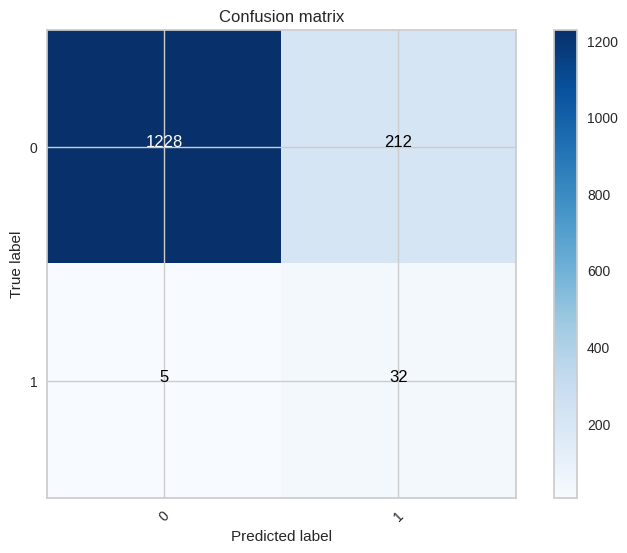

In [ ]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test1, logclassifier.predict(X_test1))
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test1, logclassifier.predict(X_test1) ))

              precision    recall  f1-score   support

           0       1.00      0.85      0.92      1440
           1       0.13      0.86      0.23        37

    accuracy                           0.85      1477
   macro avg       0.56      0.86      0.57      1477
weighted avg       0.97      0.85      0.90      1477



Logistic regression not exactly accurate in identifying potential VIP customers, is overly optimistic and predicts more customers to be potentially VIP than they actually are.

In [ ]:
from sklearn.metrics import roc_auc_score
logit_roc_auc=roc_auc_score(y_test1, logclassifier.predict(X_test1))
print(logit_roc_auc)

0.8588213213213214


In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test1, logclassifier.predict_proba(X_test1)[:,1])

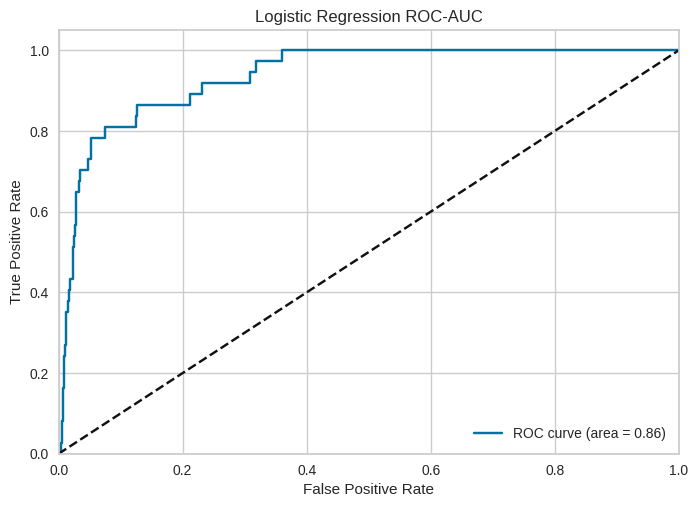

In [ ]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC-AUC')
plt.legend(loc="lower right")
plt.show()

## Random Forest

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.3, random_state=0)
os= SMOTE(random_state=0)
X_train2, y_train2 = os.fit_resample(X_train2, y_train2)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfclassifier= RandomForestClassifier(random_state=0)
rfclassifier.fit(X_train2, y_train2)

RandomForestClassifier(random_state=0)

In [ ]:
rfclassifier.predict(X_test2)

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
from sklearn.metrics import accuracy_score
print("Random Forests accuracy is %2.6f" % accuracy_score(y_test2,rfclassifier.predict(X_test2)))

Random Forests accuracy is 0.966148


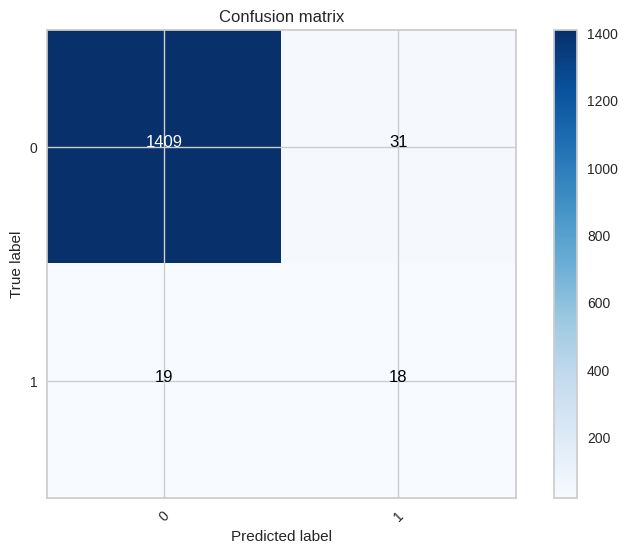

In [ ]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test2, rfclassifier.predict(X_test2))

class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test2, rfclassifier.predict(X_test2) ))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1440
           1       0.37      0.49      0.42        37

    accuracy                           0.97      1477
   macro avg       0.68      0.73      0.70      1477
weighted avg       0.97      0.97      0.97      1477



Random forest fares better, and is able to more accurately predict customers that will become VIP in a year, however it has a lower recall score.

In [ ]:
from sklearn.metrics import roc_auc_score
rf_roc_auc=roc_auc_score(y_test2, rfclassifier.predict(X_test2))
print(rf_roc_auc)

0.7324793543543543


In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test2, rfclassifier.predict_proba(X_test2)[:,1])

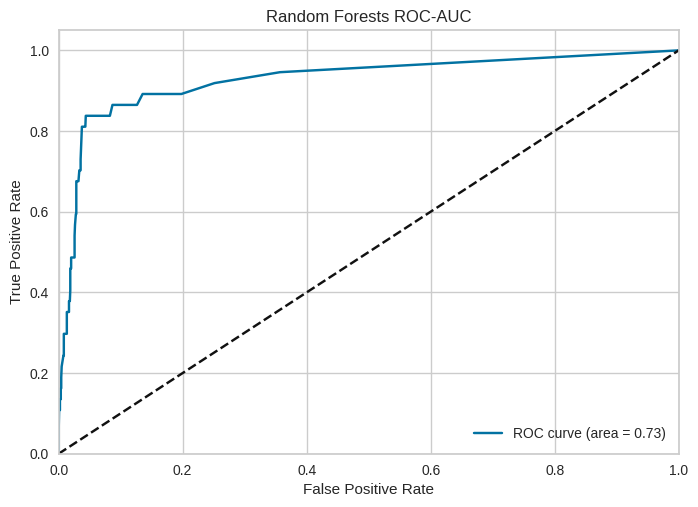

In [ ]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forests ROC-AUC')
plt.legend(loc="lower right")
plt.show()

# Cross Validation of models

In [ ]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10,shuffle=True, random_state=21)
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train, y_train = os.fit_resample(X_train, y_train)

In [ ]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([4337, 4337]))

In [ ]:
np.unique(y_test, return_counts=True)

(array([0, 1]), array([477,  15]))

## CV for logistic regression

In [ ]:
i=0
recall_all = np.array([])
precision_all = np.array([])
roc_auc_all = np.array([])

logclassifier.fit(X_train, y_train)

rec = recall_score(y_test, logclassifier.predict(X_test), average='micro')
prec = precision_score(y_test, logclassifier.predict(X_test), average='macro')
roc_auc=roc_auc_score(y_test, logclassifier.predict(X_test))

i=i+1
recall_all = np.append(recall_all, rec)
precision_all = np.append(precision_all, prec)
roc_auc_all = np.append(roc_auc_all, roc_auc)

print("average recall_score of Logistic Regression Model:", np.mean(recall_all))
print("average precision_score of Logistic Regression Model::", np.mean(precision_all))
print("average roc_auc score of Logistic Regression Model::", np.mean(roc_auc_all))

average recall_score of Logistic Regression Model: 0.8089430894308943
average precision_score of Logistic Regression Model:: 0.5688073394495413
average roc_auc score of Logistic Regression Model:: 0.9014675052410901


## CV for random forest

In [ ]:
i=0
recall_all = np.array([])
precision_all = np.array([])
roc_auc_all = np.array([])

rec = recall_score(y_test, rfclassifier.predict(X_test), average='micro')
prec = precision_score(y_test, rfclassifier.predict(X_test), average='macro')
roc_auc=roc_auc_score(y_test, rfclassifier.predict(X_test))

i=i+1
recall_all = np.append(recall_all, rec)
precision_all = np.append(precision_all, prec)
roc_auc_all = np.append(roc_auc_all, roc_auc)

print("average recall_score of Random Forests Model:", np.mean(recall_all))
print("average precision_score of Random Forests Model:", np.mean(precision_all))
print("average roc_auc score of Random Forests Model:", np.mean(roc_auc_all))

average recall_score of Random Forests Model: 0.9796747967479674
average precision_score of Random Forests Model: 0.8280922431865828
average roc_auc score of Random Forests Model: 0.8280922431865828


## Hyperparameter tuning for random forest

In [ ]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=0.3, random_state=3)
os= SMOTE(random_state=0)
X_train3, y_train3 = os.fit_resample(X_train3, y_train3)

In [ ]:
loc   = []
temp  = []
for i in range(10, 200, 10):
    new_rfclassifier= RandomForestClassifier(n_estimators=i, random_state=0)
    new_rfclassifier.fit(X_train3, y_train3)
    rf_roc_auc=roc_auc_score(y_test3, new_rfclassifier.predict(X_test3))
    loc.append(i)
    temp.append(rf_roc_auc)
rf_roc_auc_all=pd.Series(temp,loc)
print("trees","roc_auc")
print(rf_roc_auc_all)

trees roc_auc
10     0.678773
20     0.732132
30     0.732479
40     0.733174
50     0.719313
60     0.733174
70     0.732132
80     0.719660
90     0.733174
100    0.718966
110    0.720008
120    0.719660
130    0.705800
140    0.706494
150    0.720008
160    0.733174
170    0.733521
180    0.733174
190    0.733174
dtype: float64


Maximum ROC_AUC: 0.7335210210210209 at 170 trees


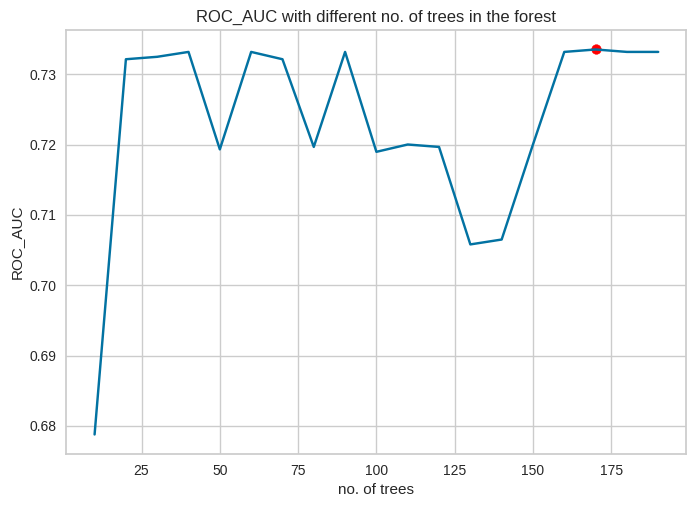

In [ ]:
max_roc_auc = rf_roc_auc_all.max()
optimal_trees = rf_roc_auc_all.idxmax()

print(f"Maximum ROC_AUC: {max_roc_auc} at {optimal_trees} trees")

plt.plot(rf_roc_auc_all.index, rf_roc_auc_all.values)
plt.xlabel('no. of trees')
plt.ylabel('ROC_AUC')
plt.title('ROC_AUC with different no. of trees in the forest')

plt.scatter(optimal_trees, max_roc_auc, color='red')
plt.show()